# Miscellaneous 2D PINN Usages

For miscellaneous uses, we showcase pulsarfitpy's ability to handle multiple missing constants in a given differential system. To do so, we sample another model adapted from [Hamil](https://arxiv.org/abs/1608.01383) and many other studies regarding the braking index $n$, frequency $\Omega$, and frequency derivative $\dot \Omega$ regarding pulsars:

$\large \dot \Omega = -K \cdot \Omega^{n}$

In this notebook, we experimentally determine an approximation for both $K$ and $n$ using pulsarfitpy & ATNF data, and how to efficiently use its multiple constant finder when solving the model.

## Making The Differential Equation Compatible with pulsarfitpy

We derive a seperate expression involving the period derivative $\dot P$ and period $P$ to abide by the three conditions of our program (refer to the Implementing 2D PINNs notebook). We first start off with the general identity of $\Omega$ in rotational dynamics, defined as the angular frequency, or:

$\large \Omega = \frac{2\pi}{P}$

Using this, we can derive an expression for $\dot \Omega$ with respect to time, seen as:

$\large \dot \Omega = -\frac{2\pi}{P^2} \dot P$

We can plug these identities into our second expression for $\dot \Omega$, resulting in the following derivations:

$\large = -\frac{2\pi}{P^2} \dot P = -K \cdot \left( \frac{2\pi}{P}  \right)^n$


$\large = 2\pi \dot P = K(2\pi)^n \cdot \frac{P^2}{P^n}$

Finally, to make it combatible with the PyTorch framework, creating a logarithmic scale is preferred to accurately train the model and its visualizations, especially with both extremely high and low values. Taking the $\log()$ of both sides yields the final expression for our model:

$\large \Rightarrow \log(\dot P) = \log(K(2\pi)^{n-1} \cdot P^{2-n})$

$\large \Rightarrow \boxed{\log(\dot P) = \log(K) + (n-1)\log(2\pi) - \log(P)}$

Since this expression fits our three criteria, we will use this theoretical framework and experimentally determine K using the PulsarPINN class below.

# Using the PulsarPINN Class with Multiple Missing Variables

Firstly, define variables and the differential equation in your code using sympy and numpy for constants.

In [1]:
import sympy as sp
import numpy as np

logP, logPDOT = sp.symbols('logP logPDOT')
logK = sp.Symbol('logK')
n = sp.Symbol('n')
C = sp.Float(np.log10(2 * np.pi)) # C = log(2pi) for simplicity

differential_equation = sp.Eq(logPDOT, logK + (n - 1) * C - logP)

Define a dictionary containing the constants that are to be learned in the PINN. An initial guess for the value is required to computationally determine if the variable needs to go higher or lower. We note that first-time guesses may not be the most accurate & may generate a lot of loss, therefore requiring multiple executions for a more accurate PINN if needed.

In [2]:
learn_constants = {logK: -14.0, n: 3.0} 

Call an instance to the PulsarPINN class and put the required information into the class, as shown. The class automatically creates a psrqpy query and fetches the psrqpy data based on the ```x_param``` and ```y_param``` inputs.

In [3]:
from pulsarfitpy import PulsarPINN

pinn = PulsarPINN(
    x_param='P0',
    y_param='P1',
    differential_eq=differential_equation,
    x_sym=logP,    # Corresponding param to P0 in logarithmic form
    y_sym=logPDOT, # Corresponding param to P1 in logarithmic form
    learn_constants=learn_constants,
    log_scale=True
)

After creating the class, the user can also have the program suggest initial guesses for the constant K using the ```.recommend_initial_guesses()``` as shown here:

In [4]:
pinn.recommend_initial_guesses(method='mean')
pinn.recommend_initial_guesses(method='regression')
pinn.recommend_initial_guesses(method='ols_loglog')

Recommended initial guesses:
  logK ≈ 2.978480e+01
  n ≈ 2.978480e+01
Recommended initial guesses:
  logK ≈ -1.446523e+01
  n ≈ 1.941372e+00
Recommended initial guesses:
  logK ≈ -1.446523e+01
  n ≈ 1.941372e+00


{logK: np.float64(-14.465233936098882), n: np.float64(1.9413724400370311)}

After inputting the needed arguments, the PINN can now start training. Simply call the ```.train()``` method in your code and enter the desired epochs for the model, and record the learned constants using ```.show_learned_constants()```.

In [5]:
pinn.train(epochs=10000)
learned_values = pinn.show_learned_constants()

Training PINN...

Epoch 0: Loss = 3.8812272241e+02 | logK=-13.9990, n=3.0010
Epoch 1000: Loss = 1.0724013333e+01 | logK=-14.1005, n=2.8995
Epoch 2000: Loss = 7.6062513056e+00 | logK=-14.6993, n=2.3007
Epoch 3000: Loss = 5.7498247474e+00 | logK=-15.2558, n=1.7442
Epoch 4000: Loss = 4.7735436417e+00 | logK=-15.6674, n=1.3326
Epoch 5000: Loss = 4.4726505463e+00 | logK=-15.9088, n=1.0912
Epoch 6000: Loss = 4.4418801186e+00 | logK=-15.9863, n=1.0137
Epoch 7000: Loss = 4.4301320168e+00 | logK=-15.9952, n=1.0048
Epoch 8000: Loss = 4.3971243839e+00 | logK=-15.9962, n=1.0038
Epoch 9000: Loss = 4.3951941747e+00 | logK=-15.9963, n=1.0037

Learned constants: logK = -15.9961527222328516728566683, n = 1.0038472798009785424966367


The user may also use the ```.plot_PINN()``` function to visualize the model in comparison to ATNF data. We note that further epochs may lead to a more accurate trend in correspondence with the ATNF data.

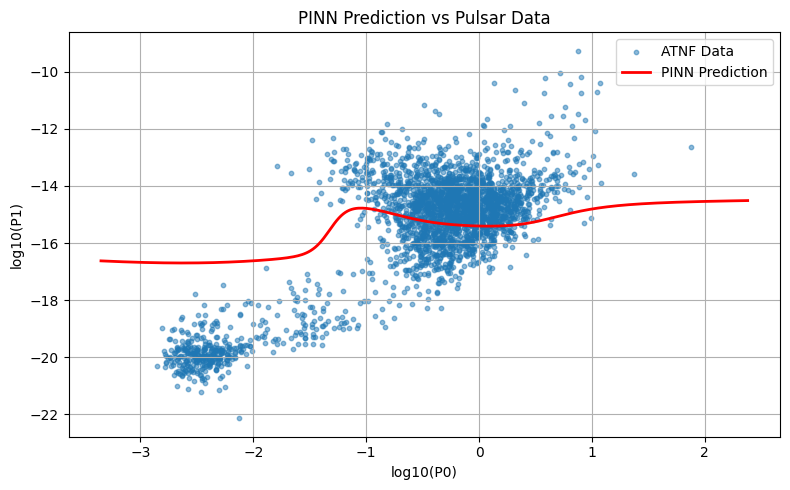

In [6]:
pinn.plot_PINN()

The user also has the option to plot the error curves during its training by calling the ```.plot_PINN_loss_curves()``` function.

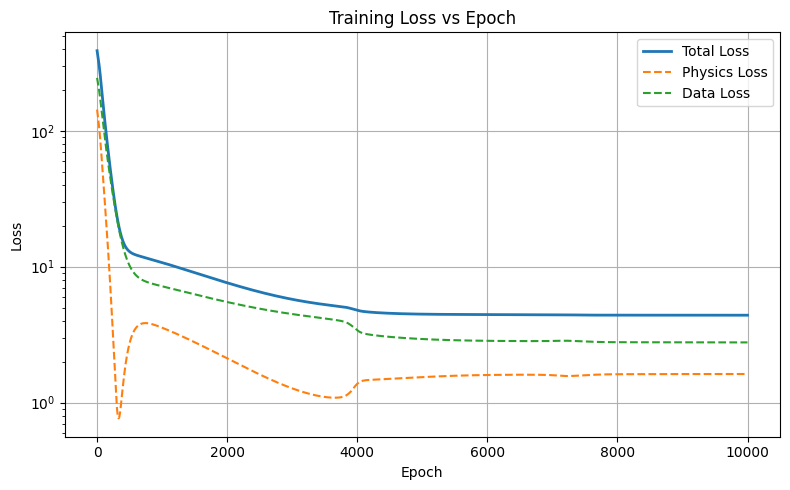

In [7]:
pinn.plot_PINN_loss()

This essentially sums up pulsarfitpy's versatile 2D PINN framework with PyTorch.